In [2]:
#! lamin init --storage ./lamin-intro --schema bionty 

import scanpy as sc
from scprint import scPrint
from scdataloader import Preprocessor
from scdataloader.utils import load_genes
import numpy as np
import anndata as ad
from huggingface_hub import hf_hub_download

from scprint.tasks import Denoiser, withknn
from scprint.model.utils import downsample_profile
from scipy.stats import spearmanr
from anndata import AnnData

import seaborn as sns
import pandas as pd
%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')

import os
import subprocess
from spatialdata_io import xenium, visium_hd
import spatialdata as sd
import spatialdata_plot

import matplotlib.pyplot as plt
from spatialdata import bounding_box_query

from pathlib import Path
import shutil

→ connected lamindb: jkobject/scprint_v2


/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


# load xenium data

In [34]:
subprocess.run(
    f"unzip -o ../data/xenium/Xenium_Prime_Human_Skin_FFPE_outs.zip -d ../data/xenium/",
    shell=True,
    check=True,
)

Archive:  ../data/xenium/Xenium_Prime_Human_Skin_FFPE_outs.zip
  inflating: ../data/xenium/analysis_summary.html  
 extracting: ../data/xenium/analysis.zarr.zip  
  inflating: ../data/xenium/cell_boundaries.csv.gz  
  inflating: ../data/xenium/cell_boundaries.parquet  
  inflating: ../data/xenium/cell_feature_matrix.h5  
 extracting: ../data/xenium/cell_feature_matrix.zarr.zip  
  inflating: ../data/xenium/cells.csv.gz  
  inflating: ../data/xenium/cells.parquet  
 extracting: ../data/xenium/cells.zarr.zip  
  inflating: ../data/xenium/experiment.xenium  
  inflating: ../data/xenium/gene_panel.json  
  inflating: ../data/xenium/metrics_summary.csv  
   creating: ../data/xenium/morphology_focus/
  inflating: ../data/xenium/morphology_focus/morphology_focus_0000.ome.tif  
  inflating: ../data/xenium/morphology_focus/morphology_focus_0001.ome.tif  
  inflating: ../data/xenium/morphology_focus/morphology_focus_0002.ome.tif  
  inflating: ../data/xenium/morphology_focus/morphology_focus_000

CompletedProcess(args='unzip -o ../data/xenium/Xenium_Prime_Human_Skin_FFPE_outs.zip -d ../data/xenium/', returncode=0)

In [ ]:
# from https://www.10xgenomics.com/datasets/xenium-prime-ffpe-human-skin
urls = [
    "https://cf.10xgenomics.com/samples/xenium/3.0.0/Xenium_Prime_Human_Skin_FFPE/Xenium_Prime_Human_Skin_FFPE_outs.zip"
]

# download the data
for url in urls:
    filename = Path(url).name
    os.makedirs("../data/xenium", exist_ok=True)
    command = f"curl -o {'../data/xenium/' + filename} {url}"
    subprocess.run(command, shell=True, check=True)

# unzip the data
subprocess.run(
    f"unzip -o ../data/xenium/Xenium_Prime_Human_Skin_FFPE_outs.zip -d ../data/xenium/",
    shell=True,
    check=True,
)

In [3]:
path_write = Path("../data/xenium/data.zarr")

In [ ]:
path_read = "../data/xenium/"

print("parsing the data... ", end="")
sdata = xenium(
    path=str(path_read),
    n_jobs=8,
    cell_boundaries=True,
    nucleus_boundaries=True,
    morphology_focus=True,
    cells_as_circles=True,
)
print("done")

print("writing the data... ", end="")
if path_write.exists():
    shutil.rmtree(path_write)
sdata.write(path_write)
print("done")

In [4]:
sdata = sd.read_zarr(path_write)
print(sdata)

Fri Jul  4 12:05:56 2025 WARNING version mismatch: detected: RasterFormatV02, requested: FormatV04
Fri Jul  4 12:05:56 2025 INFO root_attr: multiscales
Fri Jul  4 12:05:56 2025 INFO root_attr: omero
Fri Jul  4 12:05:56 2025 INFO root_attr: spatialdata_attrs
Fri Jul  4 12:05:56 2025 INFO datasets [{'coordinateTransformations': [{'scale': [1.0, 1.0, 1.0], 'type': 'scale'}], 'path': '0'}, {'coordinateTransformations': [{'scale': [1.0, 2.0, 2.0], 'type': 'scale'}], 'path': '1'}, {'coordinateTransformations': [{'scale': [1.0, 4.000394244037059, 4.0], 'type': 'scale'}], 'path': '2'}, {'coordinateTransformations': [{'scale': [1.0, 8.00236593059937, 8.00074864308441], 'type': 'scale'}], 'path': '3'}, {'coordinateTransformations': [{'scale': [1.0, 16.00473186119874, 16.004492699363535], 'type': 'scale'}], 'path': '4'}]
Fri Jul  4 12:05:56 2025 INFO resolution: 0
Fri Jul  4 12:05:56 2025 INFO  - shape ('c', 'y', 'x') = (4, 20294, 42748)
Fri Jul  4 12:05:56 2025 INFO  - chunks =  ['1', '4096 (+ 3

SpatialData object, with associated Zarr store: /home/ml4ig1/Documents code/scPRINT/notebooks/data/xenium/data.zarr
├── Images
│     └── 'morphology_focus': DataTree[cyx] (4, 20294, 42748), (4, 10147, 21374), (4, 5073, 10687), (4, 2536, 5343), (4, 1268, 2671)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (20294, 42748), (10147, 21374), (5073, 10687), (2536, 5343), (1268, 2671)
│     └── 'nucleus_labels': DataTree[yx] (20294, 42748), (10147, 21374), (5073, 10687), (2536, 5343), (1268, 2671)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 13) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (112551, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (112551, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (109795, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (112551, 5006)
with coordinate systems:
    ▸ 'global', with elements:
        morphology_focus (Images), cell_labels (Labels), nucleus_labels (Labe

In [21]:
sdata.tables['table']

AnnData object with n_obs × n_vars = 112551 × 5006
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [6]:
def crop1(x):
    return bounding_box_query(
        x,
        min_coordinate=[30_000, 2500],
        max_coordinate=[40_000, 12700],
        axes=("x", "y"),
        target_coordinate_system="global",
    )

def crop0(x):
    return bounding_box_query(
        x,
        min_coordinate=[20_000, 8000],
        max_coordinate=[22_000, 8500],
        axes=("x", "y"),
        target_coordinate_system="global",
    )

sdata.tables["table"].obs["region"] = "cell_boundaries"
sdata.set_table_annotates_spatialelement("table", region="cell_boundaries")

In [ ]:
sdata.tables["table"].raw = sdata.tables["table"].copy()
sc.pp.normalize_total(sdata.tables["table"])
sc.pp.log1p(sdata.tables["table"])
sc.pp.highly_variable_genes(sdata.tables["table"])
sdata.tables["table"].var.sort_values("means")

gene_ids    feature_types   genome  highly_variable     means  \
CYP2A6  ENSG00000255974  Gene Expression  Unknown            False  0.000013   
UPK2    ENSG00000110375  Gene Expression  Unknown            False  0.000082   
F2      ENSG00000180210  Gene Expression  Unknown            False  0.000088   
EIF1AY  ENSG00000198692  Gene Expression  Unknown            False  0.000102   
CTNND2  ENSG00000169862  Gene Expression  Unknown            False  0.000103   
...                 ...              ...      ...              ...       ...   
FBL     ENSG00000105202  Gene Expression  Unknown            False  0.956768   
LDHA    ENSG00000134333  Gene Expression  Unknown            False  0.997211   
HOXB7   ENSG00000260027  Gene Expression  Unknown             True  1.046285   
S100A1  ENSG00000160678  Gene Expression  Unknown             True  1.561527   
EEF1G   ENSG00000254772  Gene Expression  Unknown             True  1.969806   

        dispersions  dispersions_norm  
CYP2A6    -0.970586         -3.292194  
UPK2      -0.029238         -2.246485  
F2         0.063632         -2.143319  
EIF1AY     0.105529         -2.096778  
CTNND2    -0.012777         -2.228199  
...             ...               ...  
FBL        1.275202         -0.707107  
LDHA       1.416231         -0.707107  
HOXB7      2.442993          0.707107  
S100A1     2.226391          1.000000  
EEF1G      1.645159          1.000000  

[5006 rows x 7 columns]

INFO     Rasterizing image for faster rendering.                                                                   


Tue Jul  1 13:14:26 2025 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.8971626297577853].


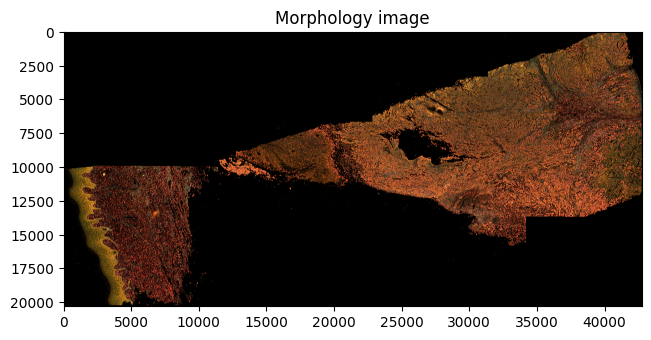

In [41]:
sdata.pl.render_images("morphology_focus").pl.show(title="Morphology image")

INFO     Rasterizing image for faster rendering.                                                                   


Tue Jul  1 14:37:24 2025 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.8790003844675125].


INFO     Rasterizing image for faster rendering.                                                                   


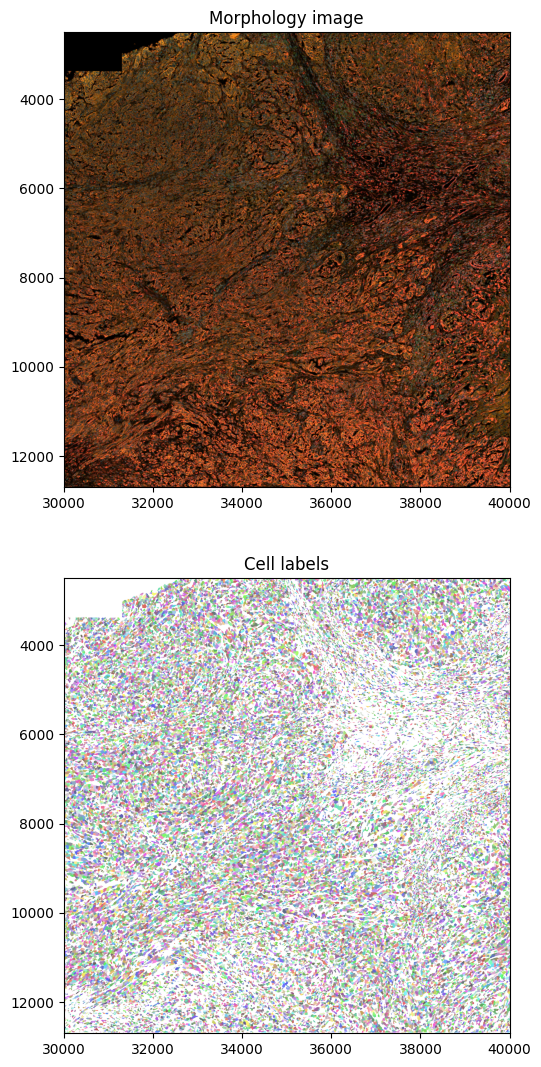

In [ ]:
axes = plt.subplots(2, 1, figsize=(20, 13))[1].flatten()

crop1(sdata).pl.render_images("morphology_focus").pl.show(
    ax=axes[0], title="Morphology image", coordinate_systems="global"
)
crop1(sdata).pl.render_labels("cell_labels").pl.show(ax=axes[1], title="Cell labels", coordinate_systems="global")

[autoreload of scprint.model.model failed: Traceback (most recent call last):
  File "/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 283, in check
    superreload(m, reload, self.old_objects)
  File "/home/ml4ig1/Documents code/scPRINT/.venv/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 483, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/home/ml4ig1/.local/share/uv/python/cpython-3.12.7-linux-x86_64-gnu/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 991, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1129, in get_code
  File "<frozen importlib._bootstrap_external>", line 1059, in source_to_code
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/home/ml4

INFO     Using 'datashader' backend with 'None' as reduction method to speed up plotting. Depending on the         
         reduction method, the value range of the plot might change. Set method to 'matplotlib' do disable this    
         behaviour.                                                                                                
INFO     Using the datashader reduction "mean". "max" will give an output very close to the matplotlib result.     


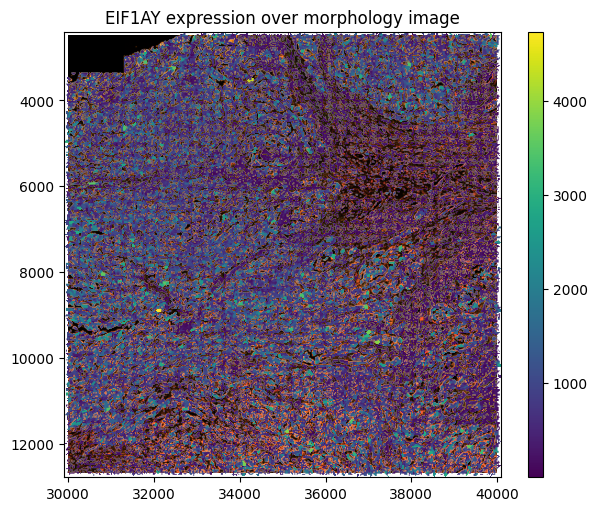

In [52]:
crop1(sdata).pl.render_images("morphology_focus").pl.render_shapes(
    "cell_boundaries",
    color="transcript_counts",
).pl.show(title=f"total transcript counts over morphology image", coordinate_systems="global", figsize=(10, 5))

Tue Jul  1 19:16:03 2025 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00021530180699730873..1.722968089196463].


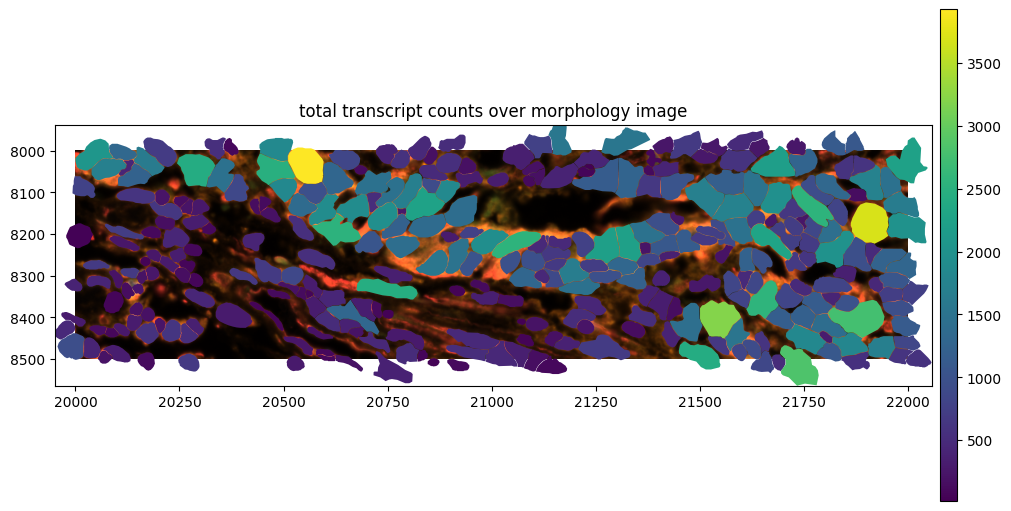

In [8]:
crop0(sdata).pl.render_images("morphology_focus").pl.render_shapes(
    "cell_boundaries",
    color="transcript_counts",
).pl.show(title=f"total transcript counts over morphology image", coordinate_systems="global", figsize=(10, 5))

Tue Jul  1 19:27:46 2025 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00021530180699730873..1.722968089196463].


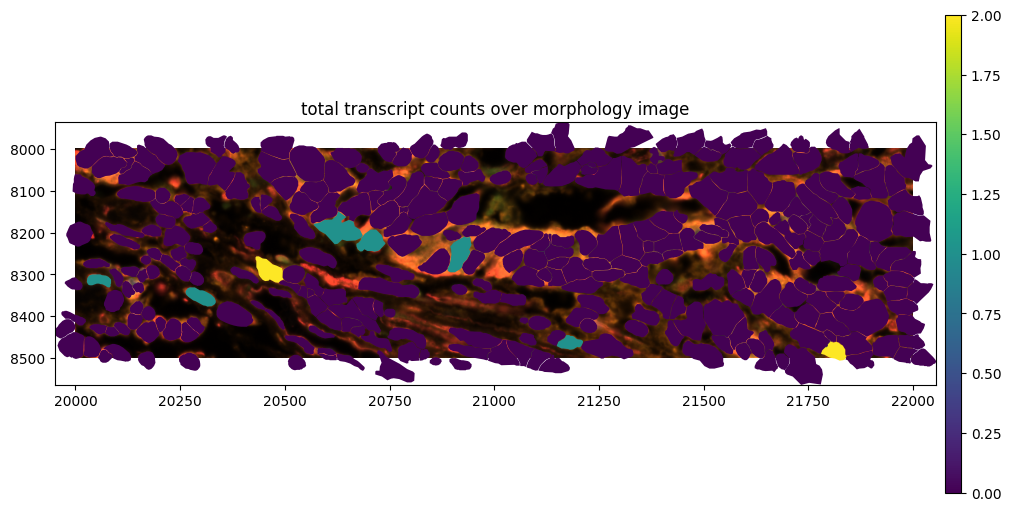

In [15]:
crop0(sdata).pl.render_images("morphology_focus").pl.render_shapes(
    "cell_boundaries",
    color="ABAT",
).pl.show(title=f"total transcript counts over morphology image", coordinate_systems="global", figsize=(10, 5))

# load the model and denoise

In [7]:
#model_checkpoint_file = hf_hub_download(
#    repo_id="jkobject/scPRINT", filename=f"v2-medium.ckpt"
#)
#model_checkpoint_file = ../data/
model_checkpoint_file = '../../../w937u4o1.ckpt'

In [8]:
model = scPrint.load_from_checkpoint(model_checkpoint_file, precpt_gene_emb=None)

FYI: scPrint is not attached to a `Trainer`.


In [9]:
subsdata = crop0(sdata)
adata = subsdata.tables["table"]
adata

AnnData object with n_obs × n_vars = 316 × 5006
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

Wed Jul  2 21:40:47 2025 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00021530180699730873..1.722968089196463].


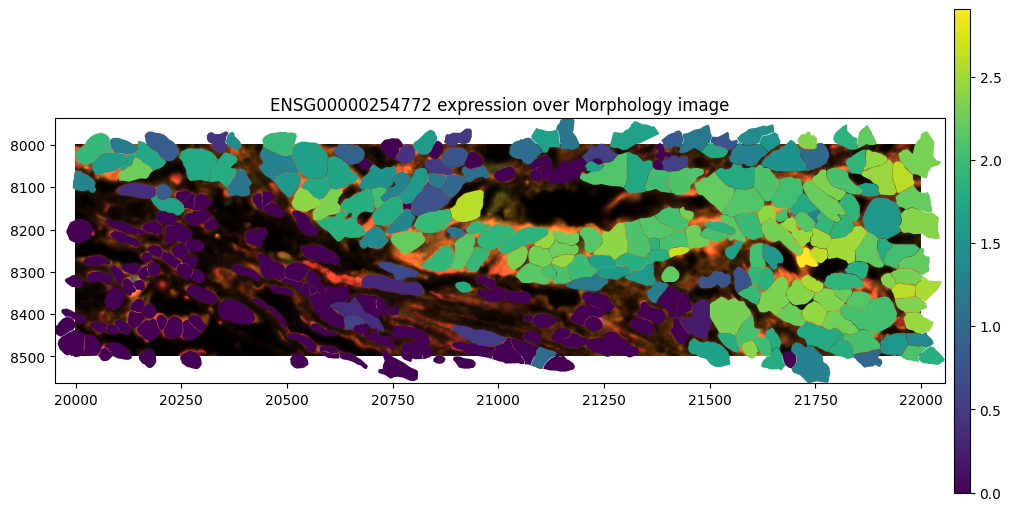

In [ ]:
subsdata.pl.render_images("morphology_focus").pl.render_shapes(
    "cell_boundaries",
    color="S100A1",#"ENSG00000254772",
).pl.show(title=f"S100A1 expression over Morphology image", coordinate_systems="global", figsize=(10, 5))

In [10]:
adata.var['gene_name'] = adata.var.index
adata.var.index = adata.var['gene_ids']
adata.obs['organism_ontology_term_id'] = 'NCBITaxon:9606'

In [11]:
preprocessor = Preprocessor(
    force_preprocess=True,
    skip_validate=True,
    #drop_non_primary=False,
    do_postp=False,
    min_valid_genes_id=200,
    keepdata=True,
    min_nnz_genes=1,

)
adata = preprocessor(adata.copy())
adata.layers['true'] = adata.X.copy()

checking raw counts
removed 0 non primary cells, 316 renamining
filtered out 0 cells, 316 renamining
Removed 0 genes not known to the ontology
Removed 0 duplicate genes
Added 65605 genes in the ontology but not present in the dataset
starting QC
Seeing 39 outliers (12.30% of total dataset):
done
AnnData object with n_obs × n_vars = 316 × 70611
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'organism_ontology_term_id', 'nnz', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outl

In [12]:
denoise = Denoiser(
    batch_size=40,
    max_len=5000,
    max_cells=30_000,
    doplot=False,
    num_workers=4,
    predict_depth_mult=10,
)
metrics, idx, nadata = denoise(model, adata)
metrics

working on 4929 accepted genes
not on wandb, could not set name


100%|██████████| 8/8 [00:16<00:00,  2.01s/it]


logging the anndata


AnnData object with n_obs × n_vars = 316 × 335182
    obs: 'pred_cell_type_ontology_term_id', 'pred_tissue_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_age_group', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'pred_cell_culture', 'conv_pred_cell_type_ontology_term_id', 'conv_pred_tissue_ontology_term_id', 'conv_pred_disease_ontology_term_id', 'conv_pred_age_group', 'conv_pred_assay_ontology_term_id', 'conv_pred_self_reported_ethnicity_ontology_term_id'
    obsm: 'scprint_emb'
    layers: 'scprint_mu', 'scprint_theta', 'scprint_pi'


In [13]:
nadata = nadata[:,nadata.layers["scprint_mu"].sum(axis=0)>1]

<Axes: title={'center': 'Unique transcripts per cell'}, xlabel='n_genes_by_counts', ylabel='Count'>

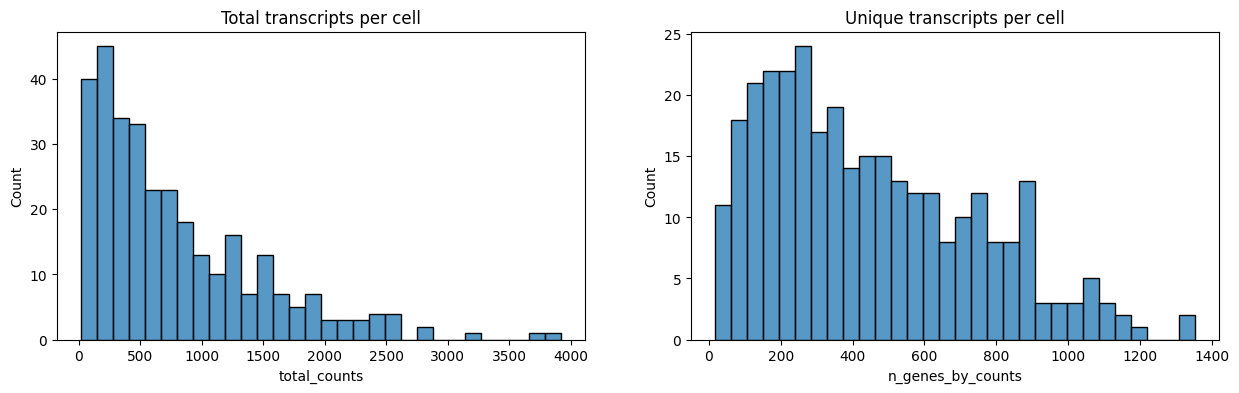

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
    bins=30,  # Increased number of bars
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
    bins=30,  # Increased number of bars
)

<Axes: title={'center': 'Unique transcripts per cell'}, xlabel='n_genes_by_counts', ylabel='Count'>

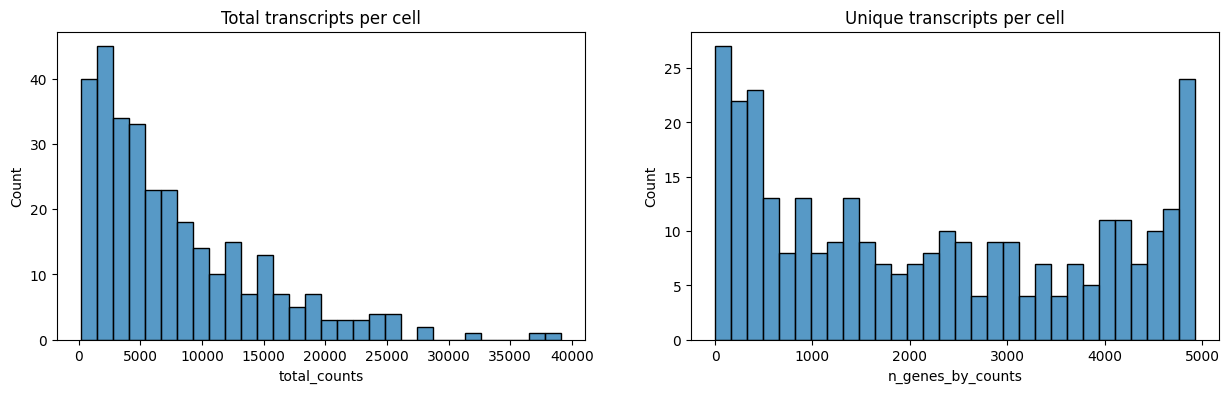

In [13]:
nadata.obs["total_counts"] = nadata.layers["scprint_mu"].sum(axis=1)
nadata.obs["n_genes_by_counts"] = (nadata.layers["scprint_mu"] > 1).sum(axis=1)

fig, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    nadata.obs["total_counts"],
    kde=False,
    ax=axs[0],
    bins=30,  # Increased number of bars
)

axs[1].set_title("Unique transcripts per cell")
sns.histplot(
    nadata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
    bins=30,  # Increased number of bars
)

/tmp/ipykernel_611964/639797741.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(nadata, resolution=1.0)


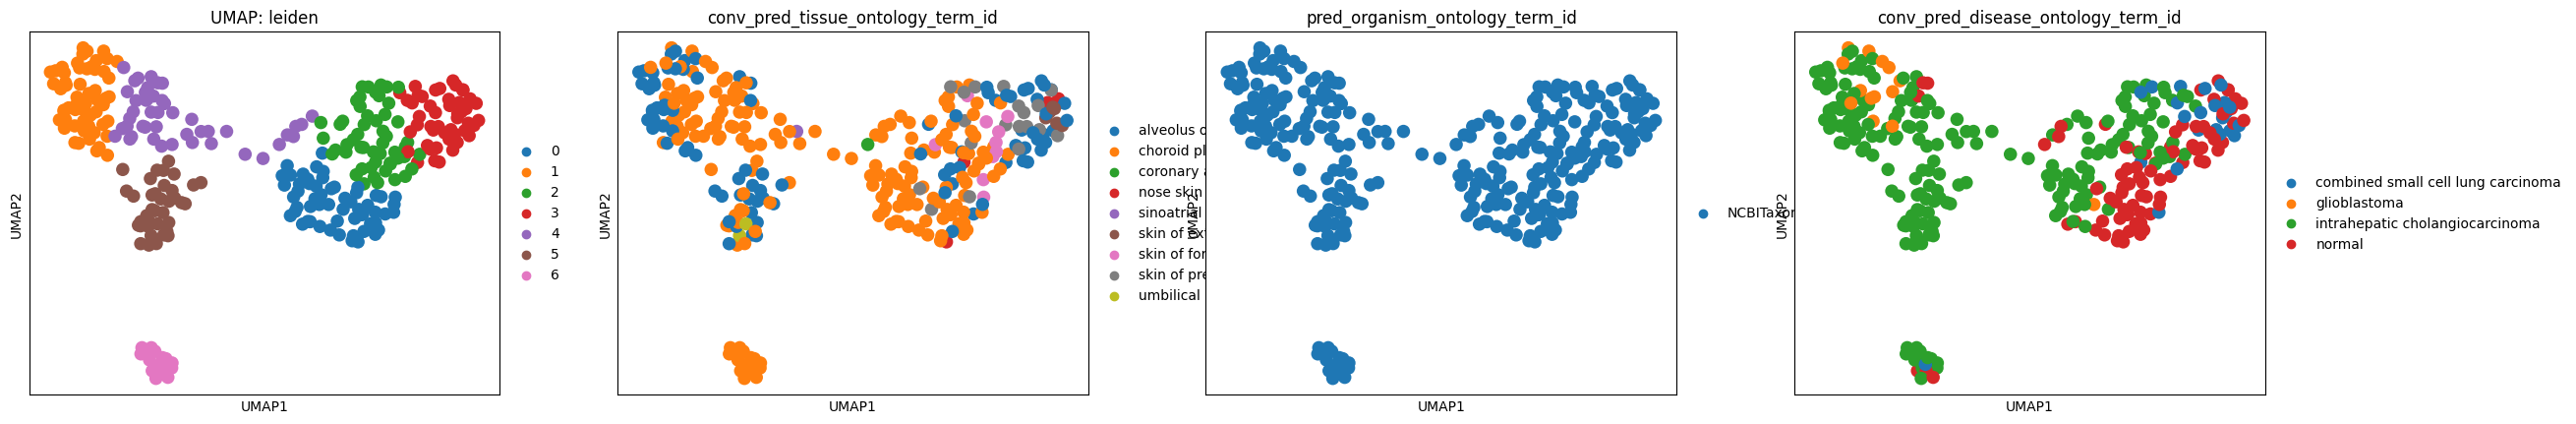

In [14]:
sc.pp.neighbors(nadata, use_rep="scprint_emb")
sc.tl.leiden(nadata, resolution=1.0)
sc.tl.umap(nadata)
sc.pl.umap(nadata, color=['leiden', 'conv_pred_tissue_ontology_term_id', 'pred_organism_ontology_term_id', 'conv_pred_disease_ontology_term_id'], title="UMAP: leiden")

In [15]:
nadata.X = nadata.layers["scprint_mu"].astype(np.int32)

In [16]:
nadata.obs.index = subsdata.tables["table"].obs.index
nadata.obs = pd.concat([nadata.obs, subsdata.tables["table"].obs], axis=1)

In [17]:
subsdata.tables["table"].var.index = subsdata.tables["table"].var.gene_ids

In [33]:
from scipy import sparse

In [ ]:
overlap = set(nadata.var_names) & set(subsdata.tables["table"].var_names)
missing = set(subsdata.tables["table"].var_names) - set(nadata.var_names)
nadata.obs = nadata.obs.loc[:, ~nadata.obs.columns.duplicated()].copy()
nadata = nadata[:, nadata.var_names.isin(overlap)]

zeros = sparse.csr_matrix((nadata.n_obs, len(missing)), dtype=nadata.X.dtype)
gene_stub = AnnData(
    X=zeros,
    obs=nadata.obs.copy(),
    var=pd.DataFrame(index=list(missing))
)
nadata = ad.concat((nadata, gene_stub), axis=1, join="outer")
# Reorder nadata to match the ordering of subsdata.tables["table"]
nadata = nadata[:, subsdata.tables["table"].var_names]

nadata.obs = subsdata.tables["table"].obs
nadata.var = subsdata.tables["table"].var


In [35]:
nadata.var.index = nadata.var.gene_name
prevdata = subsdata.tables["table"].copy()
nadata.uns = prevdata.uns

In [64]:
prevdata.var.index[np.array((prevdata.X.sum(0)<10) & (prevdata.X.sum(0)> 0))[0]].tolist()

['ABCA3',
 'ABCC3',
 'ABCC9',
 'ABCG2',
 'ABHD11',
 'ABI3BP',
 'ABTB1',
 'ACHE',
 'ACKR3',
 'ACOD1',
 'ACPP',
 'ACRBP',
 'ACVRL1',
 'ADAM28',
 'ADAMTS12',
 'ADAMTS4',
 'ADAMTS5',
 'ADAMTSL3',
 'ADGRA1',
 'ADGRB1',
 'ADGRB2',
 'ADGRE1',
 'ADGRL4',
 'ADORA2A',
 'ADORA2B',
 'ADRA1A',
 'ADRA2A',
 'ADRA2B',
 'ADRA2C',
 'ADRB1',
 'ADRB2',
 'ADTRP',
 'AFAP1L2',
 'AFG1L',
 'AFM',
 'AGER',
 'AGMAT',
 'AGRP',
 'AHRR',
 'ALOX12',
 'ALPK3',
 'ALPL',
 'AMIGO1',
 'AMIGO3',
 'ANGPT1',
 'ANGPT2',
 'ANGPTL2',
 'ANGPTL6',
 'ANGPTL7',
 'ANO1',
 'AOC3',
 'AOX1',
 'AP3B2',
 'APAF1',
 'APCDD1',
 'APLN',
 'APLNR',
 'APOBEC3B',
 'APOBEC3D',
 'APOBEC3F',
 'APOL3',
 'APOM',
 'AQP7',
 'AQP8',
 'AQP9',
 'ARC',
 'ARG2',
 'ARID3B',
 'ARMC5',
 'ARNTL',
 'ARX',
 'ASCL2',
 'ASIC1',
 'ASPN',
 'ATL1',
 'ATP6V1B1',
 'ATP7B',
 'ATXN7L2',
 'AUNIP',
 'AURKC',
 'AVPR1A',
 'AXIN2',
 'BACH2',
 'BAD',
 'BAG2',
 'BAIAP2',
 'BCAM',
 'BCL6B',
 'BDNF',
 'BEAN1',
 'BFSP1',
 'BID',
 'BIK',
 'BLM',
 'BLNK',
 'BMP5',
 'BMP6',
 'BMP8A',

In [67]:
subsdata.tables["table"] = prevdata

In [65]:
gene_name = "MYCL"

Thu Jul  3 14:56:19 2025 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00021530180699730873..1.722968089196463].


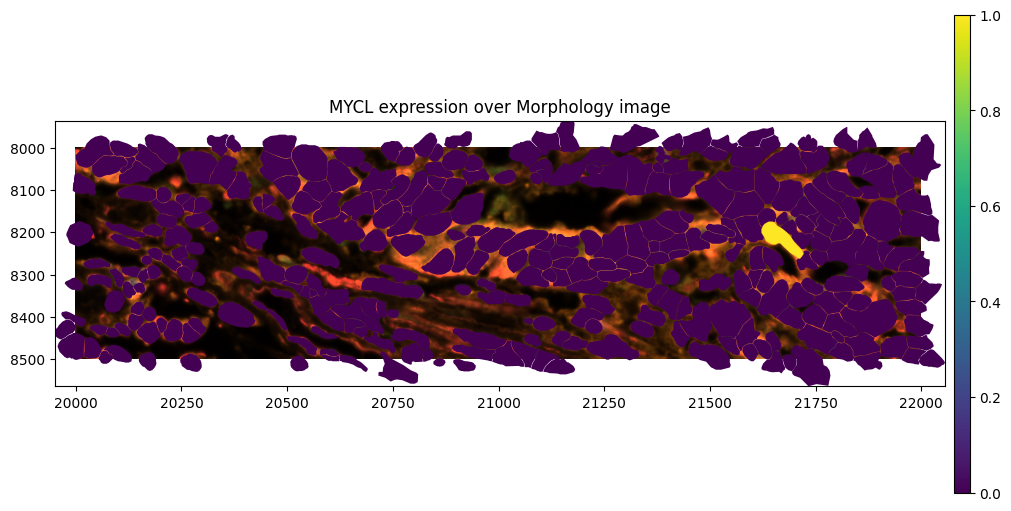

In [68]:
subsdata.pl.render_images("morphology_focus").pl.render_shapes(
    "cell_boundaries",
    color=gene_name,#"ENSG00000254772",
).pl.show(title=f"{gene_name} expression over Morphology image", coordinate_systems="global", figsize=(10, 5))

In [69]:
subsdata.tables['table'] = nadata

Thu Jul  3 14:56:25 2025 WARNING Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00021530180699730873..1.722968089196463].


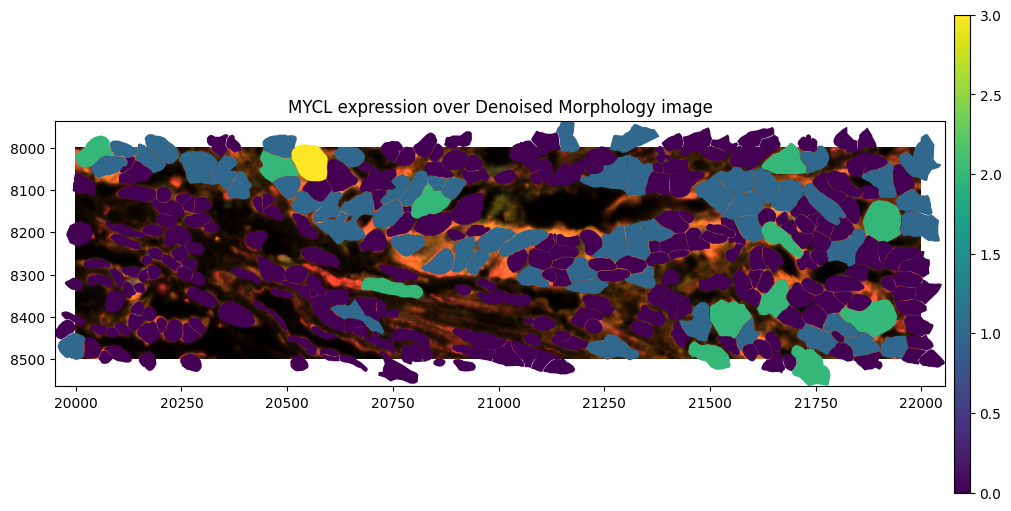

In [70]:
subsdata.pl.render_images("morphology_focus").pl.render_shapes(
    "cell_boundaries",
    color=gene_name,
).pl.show(title=f"{gene_name} expression over Denoised Morphology image", coordinate_systems="global", figsize=(10, 5))

# quantitative

### run on a large fov

In [ ]:
# comparison against magic


# alignment to single cell RNA-seq of melanoma

### diff expr again predicted cell types

### run magic on same fov